# Forecasting county-based microbusiness density levels across the 50 US states and District of Columbia

#### Devyn Duvall, Alex Johnson, Kiuk Paeng, Caio Silva, and Yuting Zhang
#### IMT 574
#### Mike Stepanovic
#### 11 March, 2023


### Linear Model, Decision Tree, and Combined Model Approach from Time Series Analysis

> ##### Code copied and adapted from Chirag Choudhary's Kaggle codebook (Feb 15th, 2023)
> #### https://www.kaggle.com/code/ch124uec/time-series-hybrid-modeling


In this investigation, we will train a series of Linear Regression models across unique counties in the dataset to eventually integrate with a larger forecasting algorithm based on decision tree regression method.

The inspiration behind the logic for this algorithm was derived from a Kaggle online course on time series-based forecasting (see Holbrook in references). In Holbrook's online course, we see method that builds forecasting algorithm via combination of linear regression and decision tree modeling.

With Linear Regression, we address seasonality to de-trend our microbusiness_density data across each unique county (cfips) series. We see the benefit and applicability of this with our first two linear model renditions.

With decision trees, we address autocorrelation cycles to fit given data and then forecast with its integration into a final combined model informed by the respective linear regression and decision tree models.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
import csv


#import plotly.figure_factory as ff
#import geopandas
#import shapely
#import plotly.express as px

import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import KBinsDiscretizer
from xgboost import XGBRegressor

from datetime import datetime
pd.options.display.float_format = '{:.4f}'.format
from tqdm import tqdm
import pickle
import plotly.express as px
import plotly.graph_objects as go
#!pip install forecast
#from forecast import smape
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import warnings
warnings.filterwarnings('ignore')

In [2]:
census_path = ""
train_path = ""
test_path = ""
sample_path = ""
revealed_path = ""

census_df = pd.read_csv(census_path)
census_df = pd.DataFrame(census_df)

sample_df = pd.read_csv(sample_path)
sample_df = pd.DataFrame(sample_df)

# filling the NaNs
numeric_cols = census_df.select_dtypes(include = ['float64', 'int64']).columns
imputer = SimpleImputer(strategy = 'mean').fit(census_df[numeric_cols])
census_df[numeric_cols] = imputer.transform(census_df[numeric_cols])

test_df = pd.read_csv(test_path)
test_df = pd.DataFrame(test_df)

train_df = pd.read_csv(train_path)
train_df = pd.DataFrame(train_df)

revealed_df = pd.read_csv(revealed_path)
revealed_df = pd.DataFrame(revealed_df)
revealed_df

train_df = pd.concat([train_df, revealed_df], ignore_index=True)

In [ ]:
# Read in the data
#census_df = pd.read_csv('census_starter.csv', sep=",",header=0)
#census_df = pd.DataFrame(census_df)
#census_df = census_df.apply(pd.to_numeric, errors='coerce').fillna(census_df)

#sample_df = pd.read_csv('sample_submission.csv', sep=",",header=0)
#sample_df = pd.DataFrame(sample_df)

# filling the NaNs
#numeric_cols = census_df.select_dtypes(include = ['float64', 'int64']).columns
#imputer = SimpleImputer(strategy = 'mean').fit(census_df[numeric_cols])
#census_df[numeric_cols] = imputer.transform(census_df[numeric_cols])

# Read in the data (again)
#test_df = pd.read_csv('test.csv', sep=",",header=0)
#test_df = pd.DataFrame(test_df)

#train_df = pd.read_csv('train.csv', sep=",",header=0)
#train_df = pd.DataFrame(train_df)

#revealed_df = pd.read_csv('revealed_test.csv', sep=",",header=0)
#revealed_df = pd.DataFrame(revealed_df)

#train_df = pd.concat([train_df, revealed_df], ignore_index=True)

In [3]:
test_df = test_df.merge(train_df[['cfips', 'county', 'state']].drop_duplicates(), how='left')

In [4]:
test_df.head()

row_id  cfips first_day_of_month          county    state
0  1001_2022-11-01   1001         2022-11-01  Autauga County  Alabama
1  1003_2022-11-01   1003         2022-11-01  Baldwin County  Alabama
2  1005_2022-11-01   1005         2022-11-01  Barbour County  Alabama
3  1007_2022-11-01   1007         2022-11-01     Bibb County  Alabama
4  1009_2022-11-01   1009         2022-11-01   Blount County  Alabama

In [5]:
train_df.head()

row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active  
0                 3.0077    1249  
1                 2.8849    1198  
2                 3.0558    1269  
3                 2.9932    1243  
4                 2.9932    1243

Target variable will be 'microbusiness_density'

In [6]:
target = 'microbusiness_density'

In [7]:
# merge train and test sets for main df
df = pd.concat([train_df, test_df])

df['row_id'] = df['row_id'].str.split('_', expand=True)[0]
df['first_day_of_month'] = pd.to_datetime(df['first_day_of_month'])
df['state_fips'] = df['cfips'] // 1000
df['county_fips'] = df['cfips'] % 1000

train_df = df.iloc[:len(train_df)]
test_df = df.iloc[len(train_df):]

### A baseline linear regression model

According to Holbrook's "Time series" seminar (see Kaggle.com), linear regression models can be adapted to time series data in flexible manners such
that we may model higher order polynomial regressors to fit data.

For the linear baseline model below, we begin by plotting microbusiness_density
growth for one county over the entire time series (July, 2019-January, 2023).

For each cfips value across the dataset, we must tailor our regression algorithm to fit a unique county's linear regression curve. 

To customize each regression and define its approach to capturing the moving average of our microbusiness_density values across the set, we call a new 'y_pred' to difference each county-based series.

With this first linear regression, we will simply look at regressions across order 1-4 to identify the model with best residual minimization.

In [8]:
# create rule to randomly draw a bucket featuring a singular cfip (county) 
# series of  microbusiness_density measures across the 4yr data
cfips = np.random.choice(train_df['cfips'])
cfips

6065

With 42131 unique dates identified in our time series over 41 months, we can already begin to methodically approach constructing this time series iteratively based on county-level data.

Taking note that each county may not have a complete set of microbusiness_density datum across the set due to duplicate removal or non-reporting, this approach's logic makes better sense.

In [9]:
# temporary subset_df contains 41 values of microbusiness data
subset_df = train_df.loc[train_df['cfips']==cfips].set_index(['first_day_of_month'])
subset_df.shape

(41, 8)

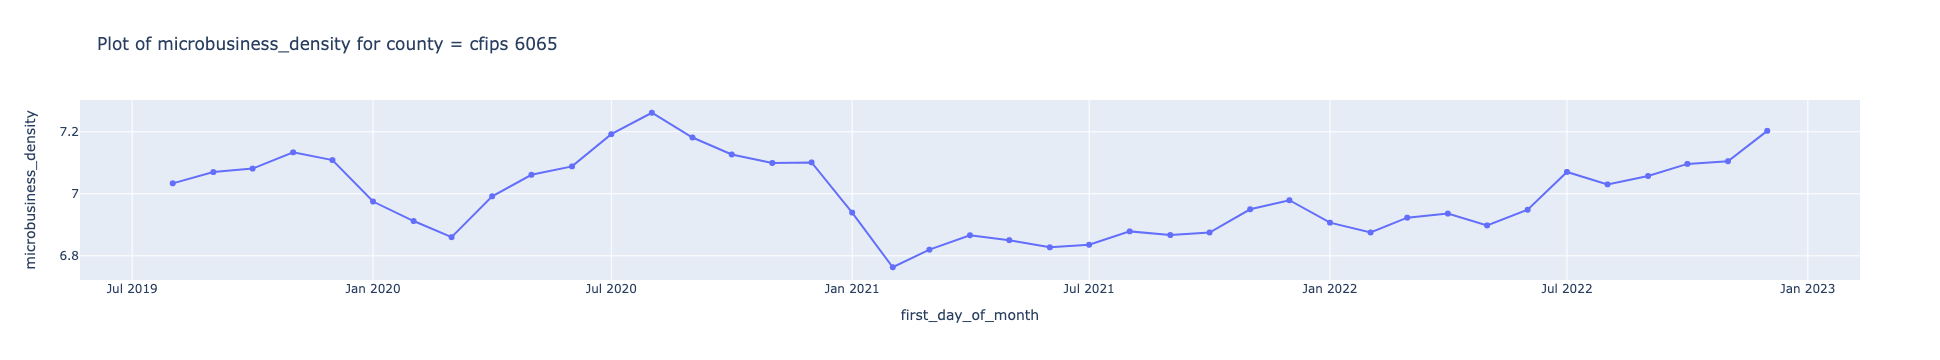

In [10]:
fig = px.line(subset_df, y=target, markers=True, 
              title=f"Plot of {target} for county = cfips {cfips}")
fig.show()

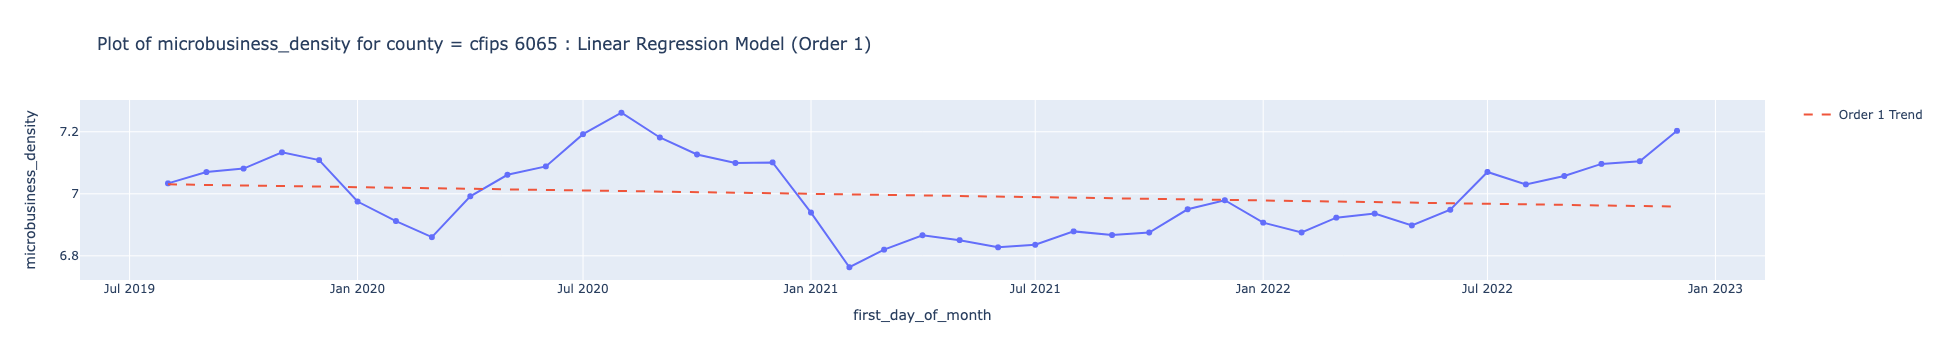

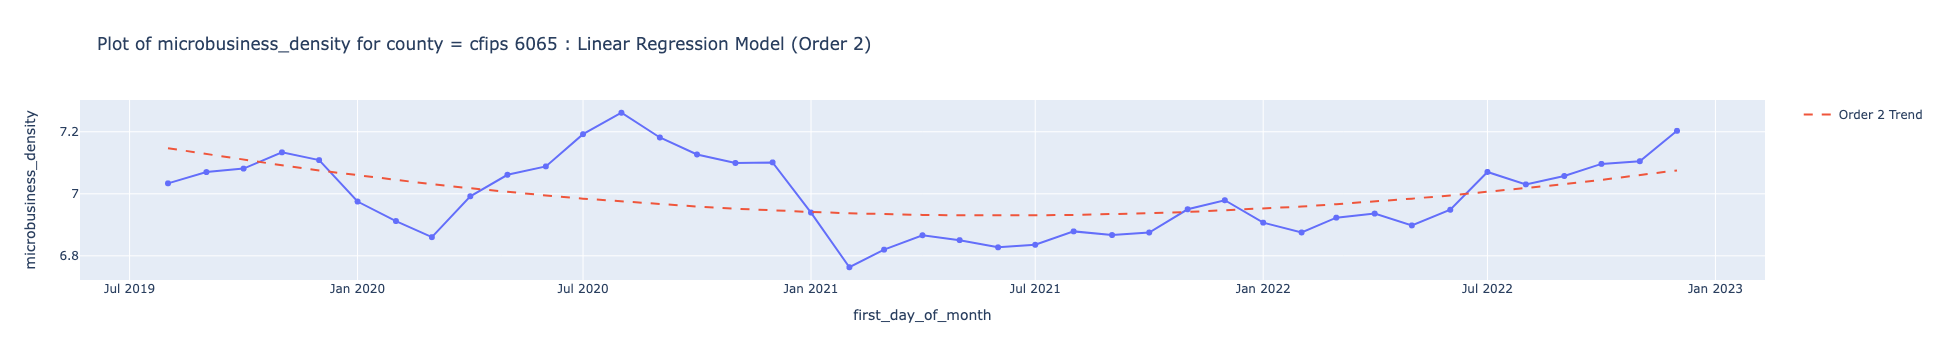

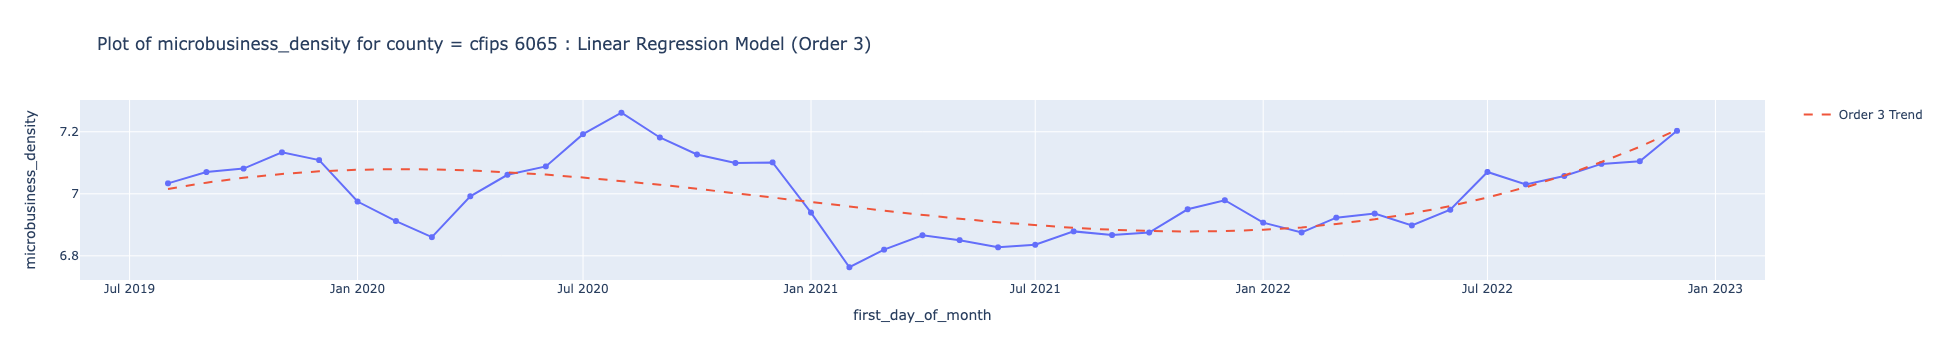

The best model is the one with order 3, which has a cumulative residual valuation of 0.33, a mean squared error of 0.01, and a SMAPE of 0.24%.


In [11]:
lowest_resid = float('inf')
lowest_mse = float('inf')
lowest_smape = float('inf')
best_model_order = None

for n in range(3):
    dp = DeterministicProcess(
        index=subset_df.index,
        constant=True,
        order=n+1,
        drop=True,
    )

    X = dp.in_sample()
    y = subset_df[target]

    trend_model = LinearRegression()
    trend_model.fit(X, y)

    y_pred = pd.Series(trend_model.predict(X), index=X.index)

    fig = px.line(subset_df, y=target, markers=True, 
                  title=f"Plot of {target} for county = cfips {cfips} : Linear Regression Model (Order {n+1})")
    
    fig.add_scatter(x=y_pred.index, y=y_pred, line=dict(dash='dash'), name=f"Order {n+1} Trend")
    
    fig.update_layout(showlegend=True)
    fig.show()
    
    # Compute cumulative residual valuation, mean squared error, and SMAPE
    resid_val = ((y - y_pred)**2).sum()
    mse_val = mean_squared_error(y, y_pred)
    smape_val = np.mean(np.abs((y - y_pred) / (y + y_pred) / 2)) * 100
    
    # Check if current model has lower residual valuation, mean squared error, or SMAPE
    if resid_val < lowest_resid:
        lowest_resid = resid_val
        best_model_order = n+1
        
    if mse_val < lowest_mse:
        lowest_mse = mse_val
        
    if smape_val < lowest_smape:
        lowest_smape = smape_val
        
# Print out results for model with lowest cumulative residual valuation, mean squared error, and SMAPE
print(f"The best model is the one with order {best_model_order}, which has a cumulative residual valuation of {lowest_resid:.2f}, a mean squared error of {lowest_mse:.2f}, and a SMAPE of {lowest_smape:.2f}%.") 


#### Noting best model iterant accuracy in order 3 polynomial fit

In terms of mean squared error and cumulative residuals, we see that the linear model can be improved perhaps with more appropriate time-based treatment of our series; this will be addressed with a seasonality-informed linear model.

### Linear Regression Model--Seasonality Rendition

We follow Holbrook's method from the Kaggle time series course to difference and then use a seasonality hyperparameter in the 'DeterministicProcess' function to better approximate our target value (microbusiness_density)--effectively, this is "de-trending" the series.

For the last baseline linear regression where we indexed solely with respect to the subset_df's 'first_day_of_the_month' feature, we now index the new model with respect to the entire series of microbusiness_density valuations.

This widescale view will help to identify seasonal-based trends with the addition of 'seasonal = True' hyperparameter. 

How much more accurate can linear approximation be with these tunings?

In [12]:
# Differencing for stationising time series
y = y - y_pred

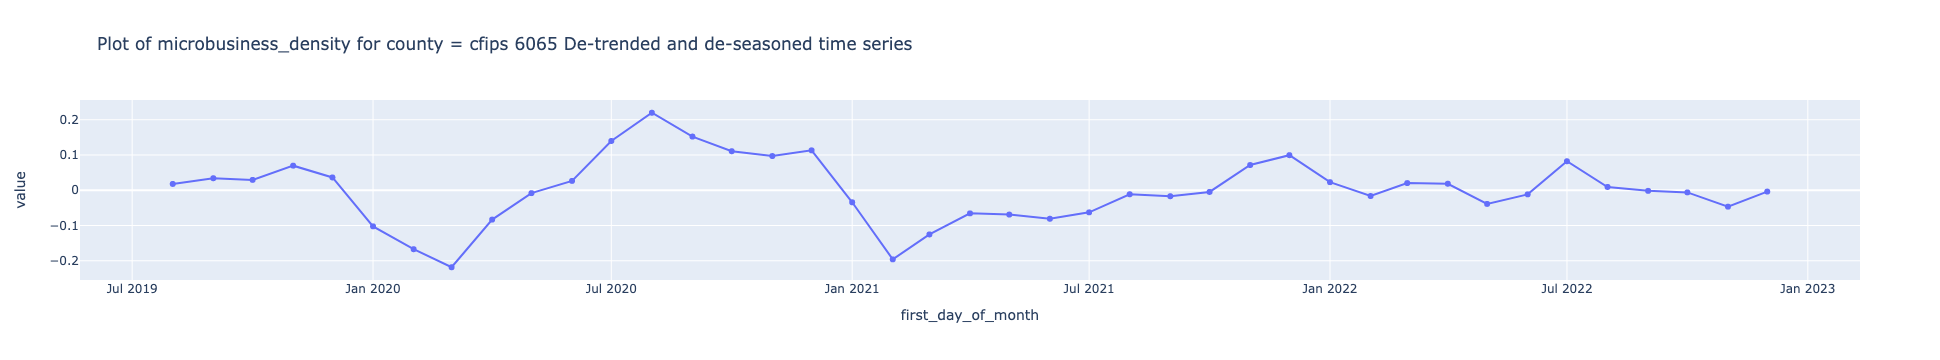

In [13]:
fig = px.line(y, markers=True, title=f"Plot of {target} for county = cfips {cfips} De-trended and de-seasoned time series")
fig.update_layout(showlegend=False)
fig.show()

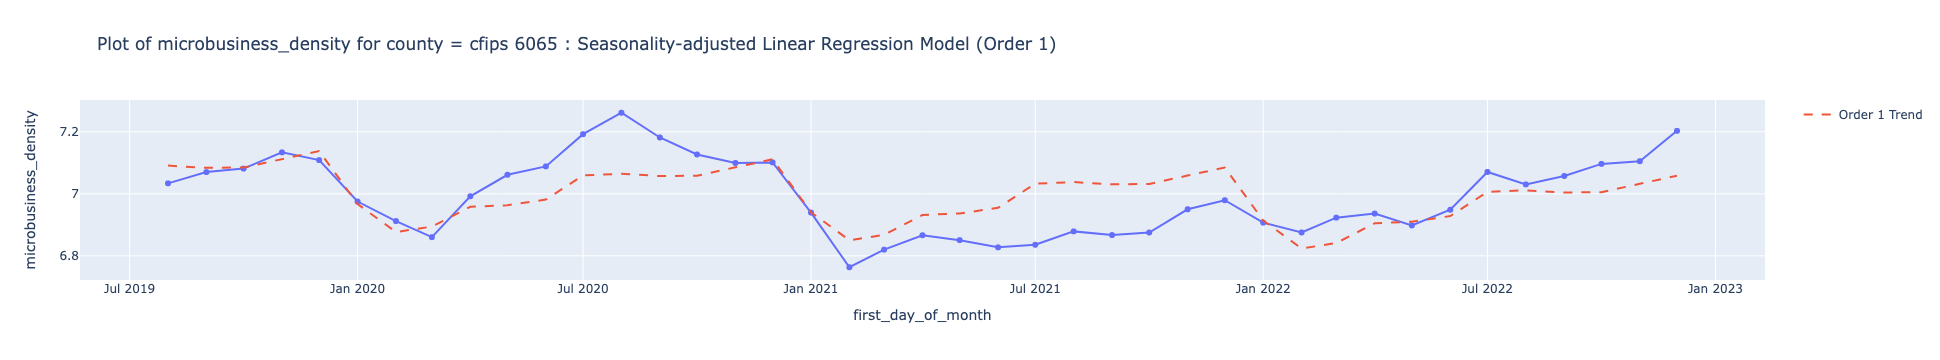

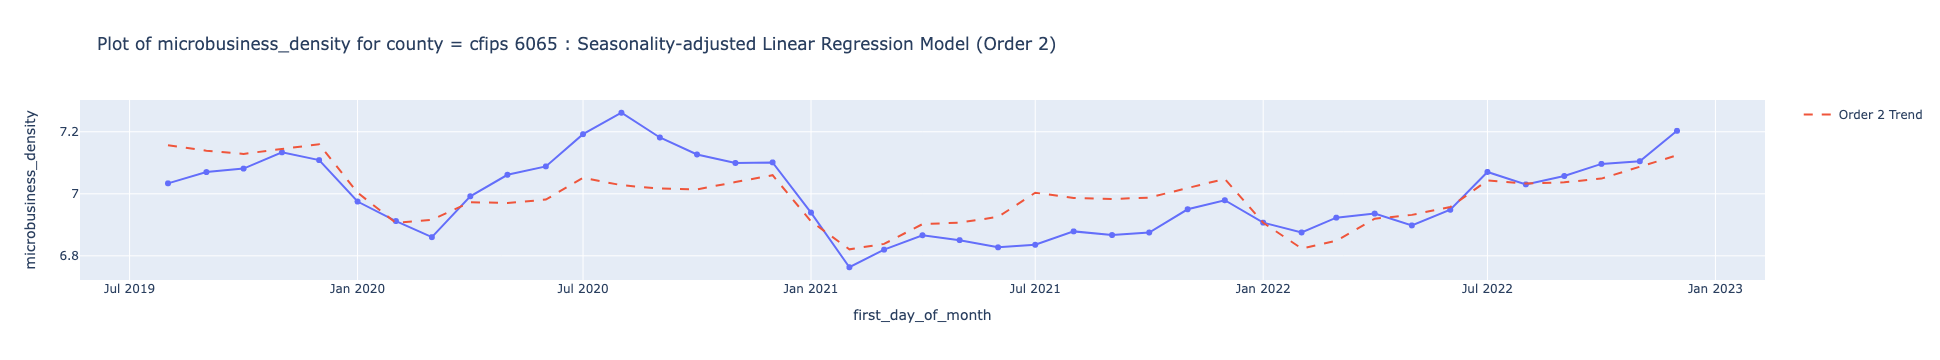

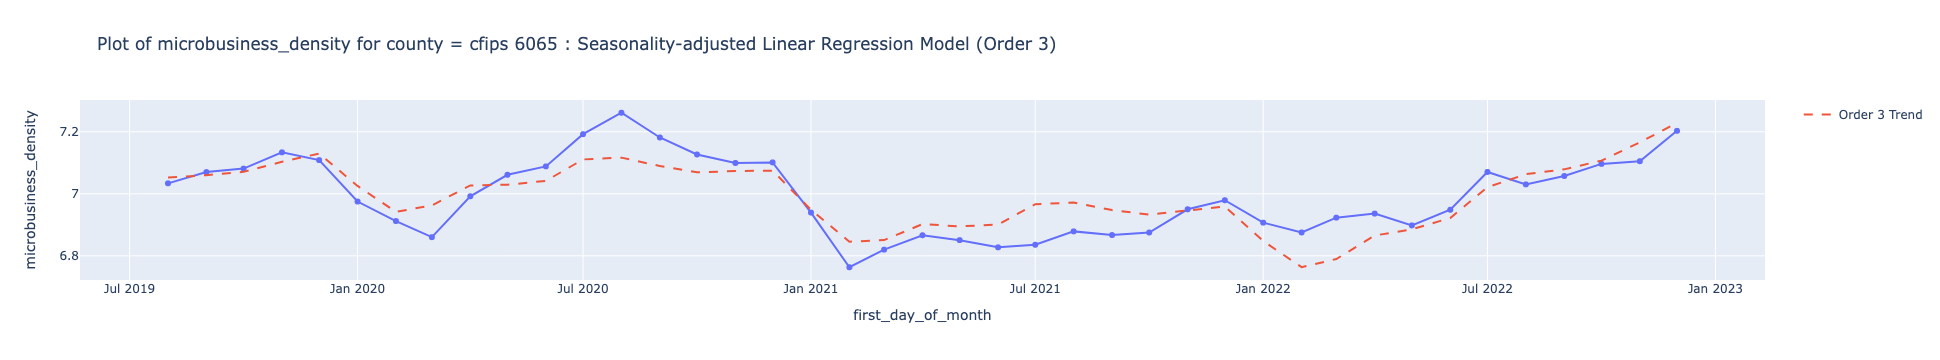

The best model is the one with order 3, which has a cumulative residual valuation of 0.16, a mean squared error of 0.00, and a SMAPE of 0.18%.


In [14]:
lowest_resid = float('inf')
lowest_mse = float('inf')
lowest_smape = float('inf')
best_model_order = None

for n in range(3):
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=n+1,
        seasonal=True,
    )

    X = dp.in_sample()
    y = subset_df[target]

    seasonality_model = LinearRegression()
    seasonality_model.fit(X, y)

    y_pred = pd.Series(seasonality_model.predict(X), index=X.index)

    fig = px.line(subset_df, y=target, markers=True, 
                  title=f"Plot of {target} for county = cfips {cfips} : Seasonality-adjusted Linear Regression Model (Order {n+1})")
    
    fig.add_scatter(x=y_pred.index, y=y_pred, line=dict(dash='dash'), name=f"Order {n+1} Trend")
    
    fig.update_layout(showlegend=True)
    fig.show()
    
    # Compute cumulative residual valuation and mean squared error
    resid_val = ((y - y_pred)**2).sum()
    mse_val = mean_squared_error(y, y_pred)
    smape_val = np.mean(np.abs((y - y_pred) / (y + y_pred) / 2)) * 100
    
    # Check if current model has lower residual valuation or mean squared error
    if resid_val < lowest_resid:
        lowest_resid = resid_val
        best_model_order = n+1
        
    if mse_val < lowest_mse:
        lowest_mse = mse_val
        
        
    if smape_val < lowest_smape:
        lowest_smape = smape_val
        
# Print out results for model with lowest cumulative residual valuation and mean squared error
print(f"The best model is the one with order {best_model_order}, which has a cumulative residual valuation of {lowest_resid:.2f}, a mean squared error of {lowest_mse:.2f}, and a SMAPE of {lowest_smape:.2f}%.")

### Decision Tree Regressor Model

Having minimized error across MSE and cumulative residual valuations in the seasonality-adjusted linear model above, we now turn to the decision tree model to see how we can impact accuracy.

In [15]:
X = dp.in_sample()
X.head()

const  trend  trend_squared  trend_cubed  s(2,12)  \
first_day_of_month                                                      
2019-08-01         1.0000 1.0000         1.0000       1.0000   0.0000   
2019-09-01         1.0000 2.0000         4.0000       8.0000   1.0000   
2019-10-01         1.0000 3.0000         9.0000      27.0000   0.0000   
2019-11-01         1.0000 4.0000        16.0000      64.0000   0.0000   
2019-12-01         1.0000 5.0000        25.0000     125.0000   0.0000   

                    s(3,12)  s(4,12)  s(5,12)  s(6,12)  s(7,12)  s(8,12)  \
first_day_of_month                                                         
2019-08-01           0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
2019-09-01           0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
2019-10-01           1.0000   0.0000   0.0000   0.0000   0.0000   0.0000   
2019-11-01           0.0000   1.0000   0.0000   0.0000   0.0000   0.0000   
2019-12-01           0.0000   0.0000   1.0000   0.0000   0.0000   0.0000   

                    s(9,12)  s(10,12)  s(11,12)  s(12,12)  
first_day_of_month                                         
2019-08-01           0.0000    0.0000    0.0000    0.0000  
2019-09-01           0.0000    0.0000    0.0000    0.0000  
2019-10-01           0.0000    0.0000    0.0000    0.0000  
2019-11-01           0.0000    0.0000    0.0000    0.0000  
2019-12-01           0.0000    0.0000    0.0000    0.0000

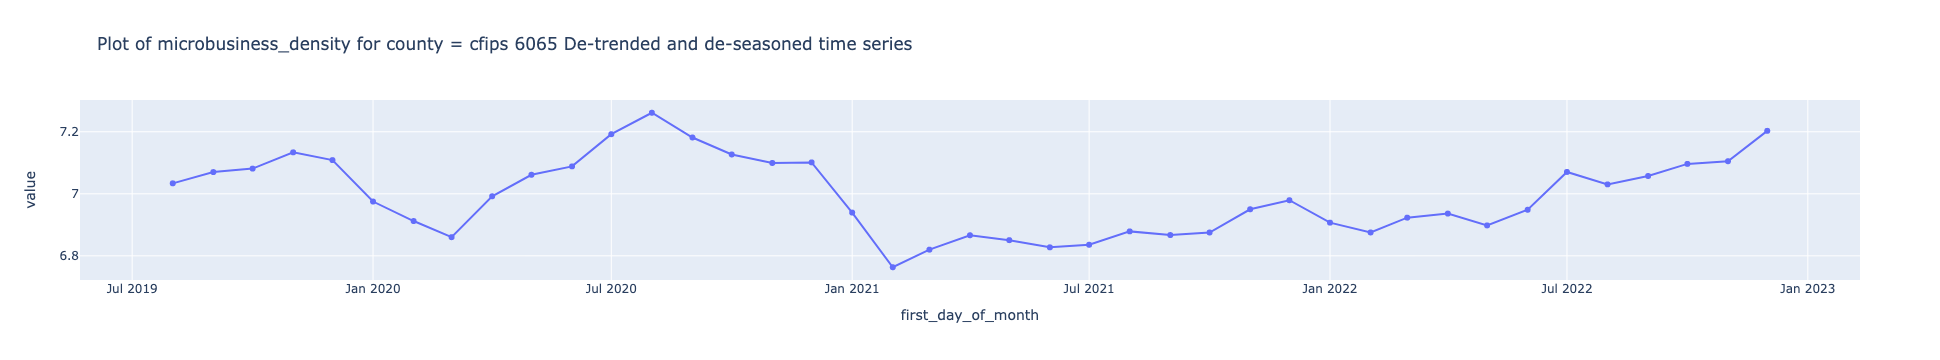

In [16]:
fig = px.line(y, markers=True, 
              title=f"Plot of {target} for county = cfips {cfips} De-trended and de-seasoned time series")
fig.update_layout(showlegend=False)
fig.show()

In [17]:
y = y - y_pred

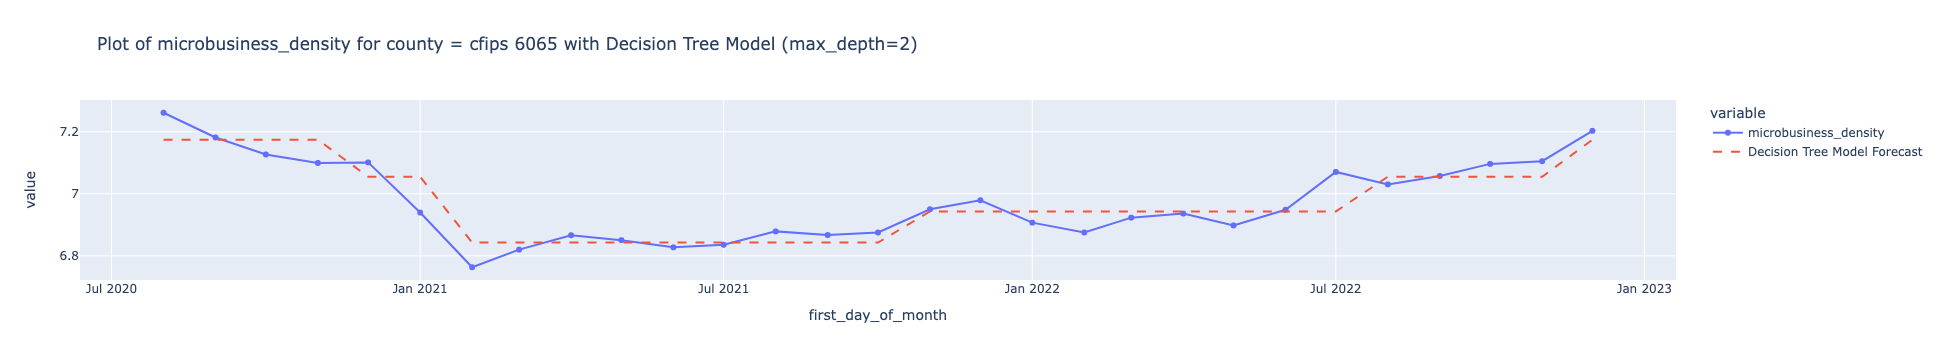

The Decision Tree model with max_depth=2 has a SMAPE of 0.56.


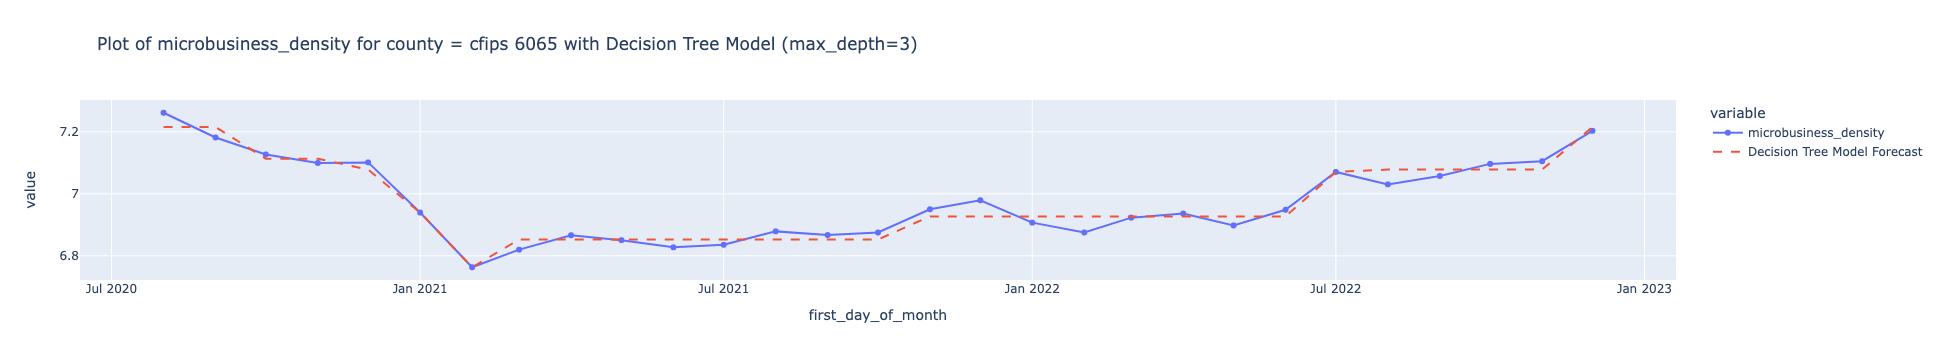

The Decision Tree model with max_depth=3 has a SMAPE of 0.31.


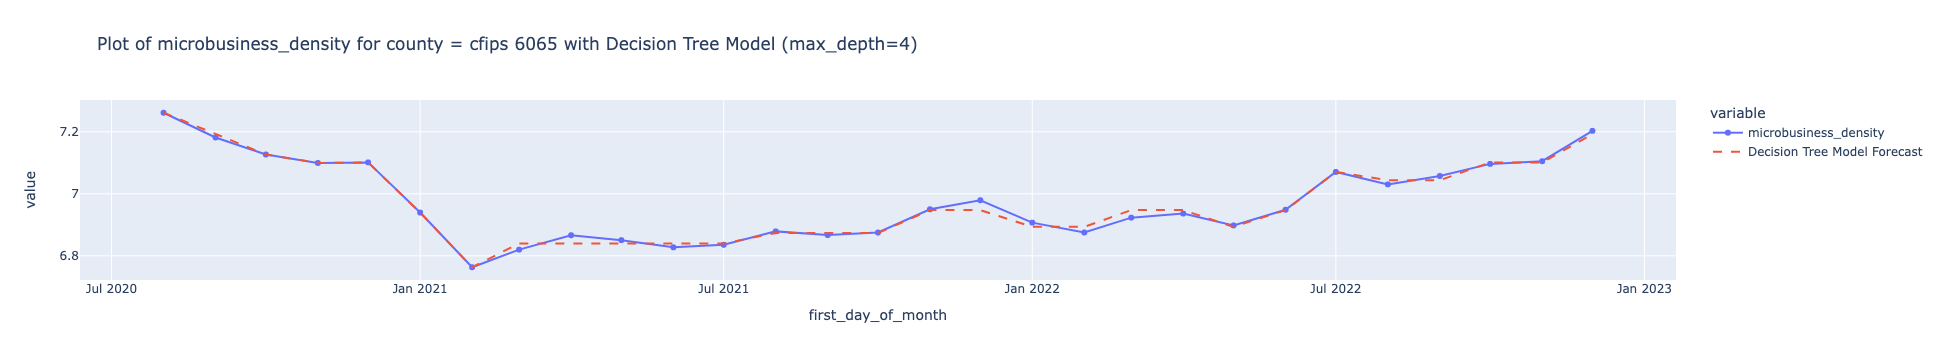

The Decision Tree model with max_depth=4 has a SMAPE of 0.13.


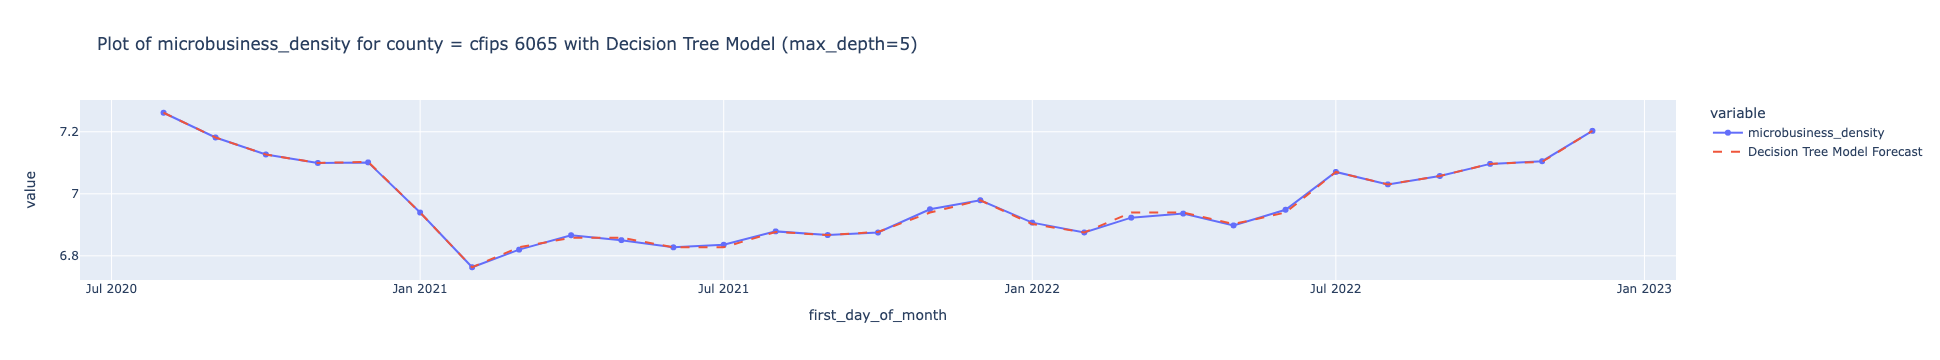

The Decision Tree model with max_depth=5 has a SMAPE of 0.04.


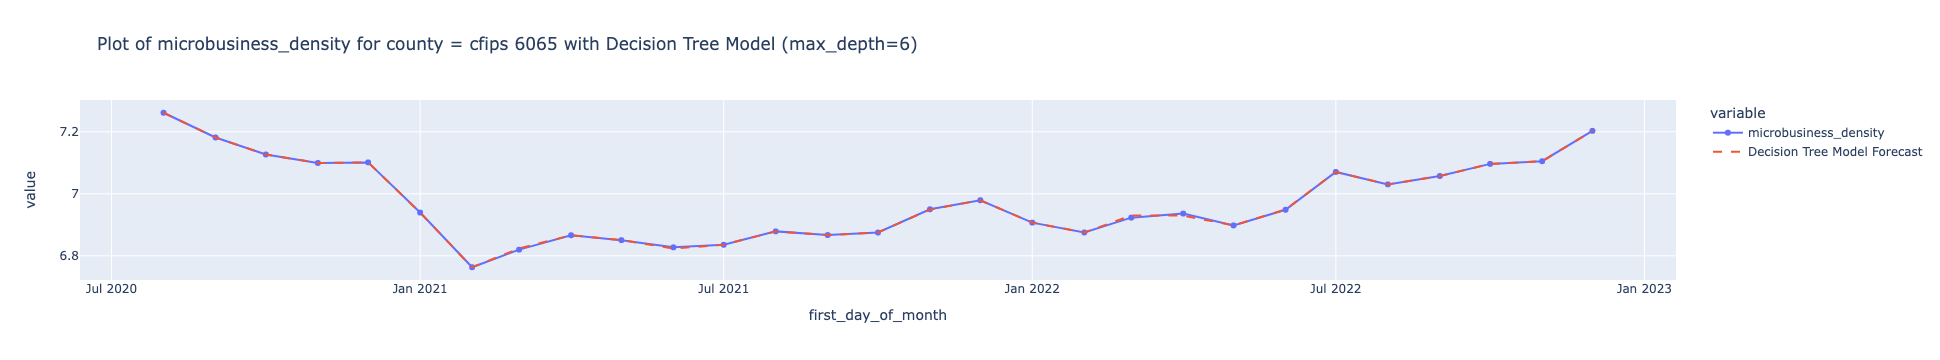

The Decision Tree model with max_depth=6 has a SMAPE of 0.01.


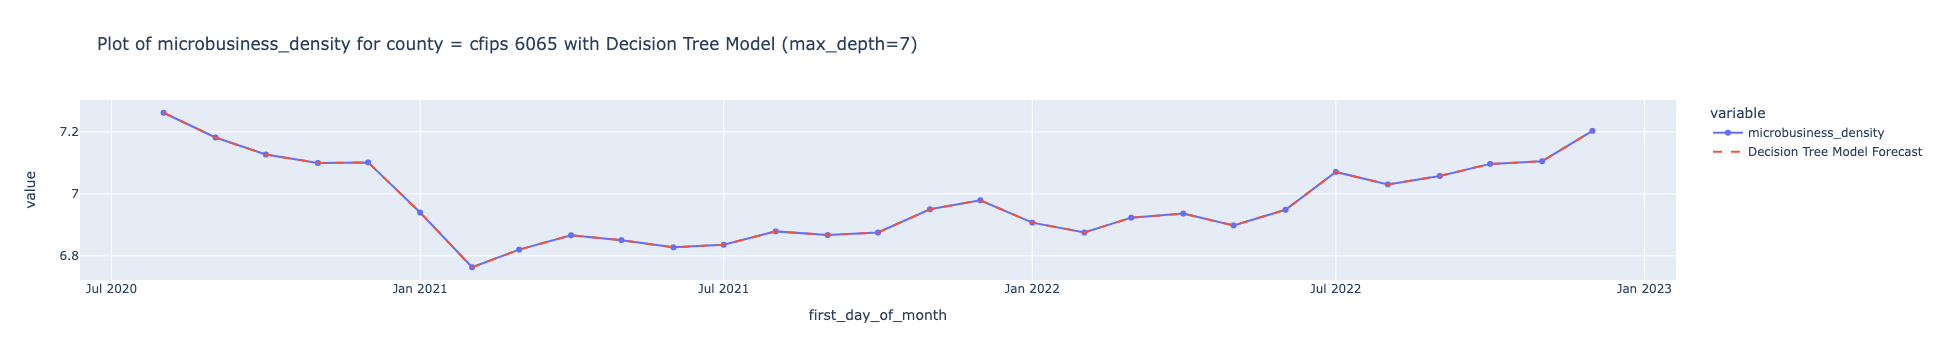

The Decision Tree model with max_depth=7 has a SMAPE of 0.00.


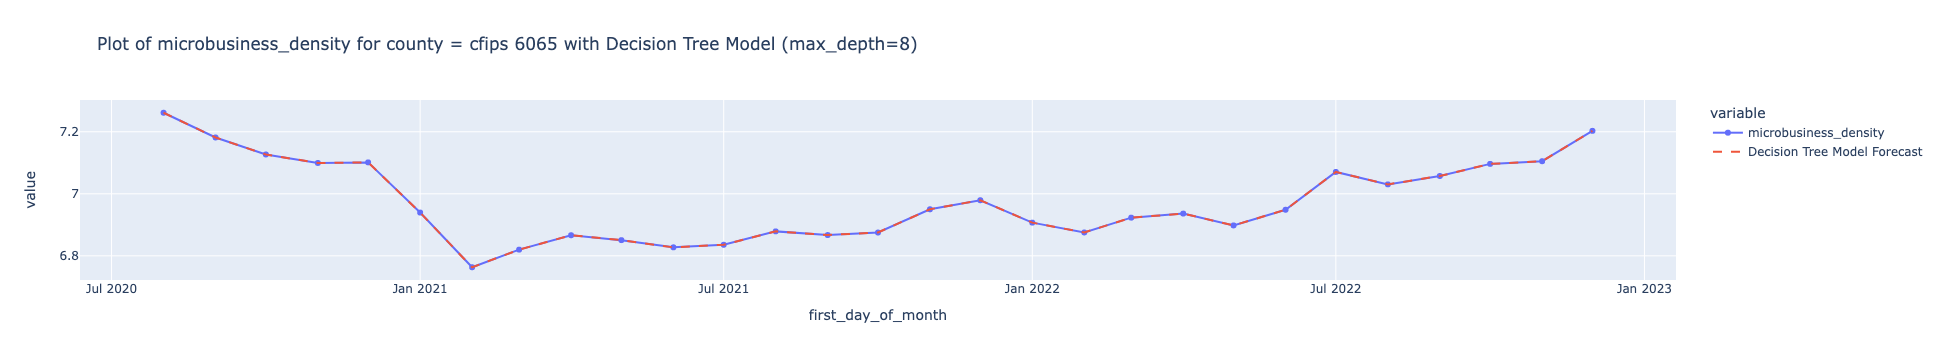

The Decision Tree model with max_depth=8 has a SMAPE of 0.00.


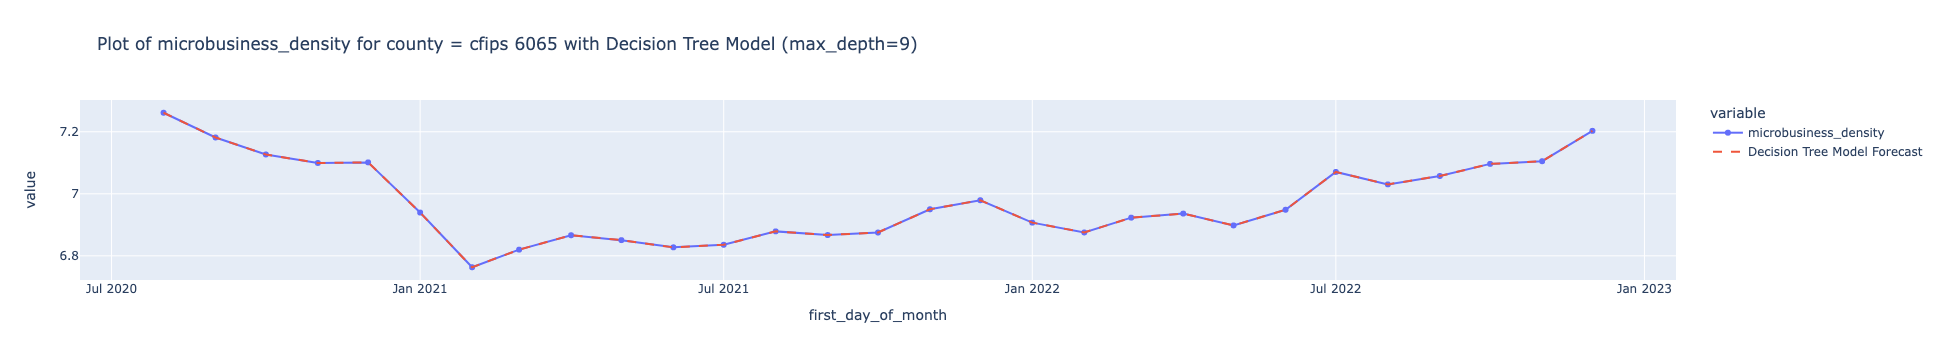

The Decision Tree model with max_depth=9 has a SMAPE of 0.00.


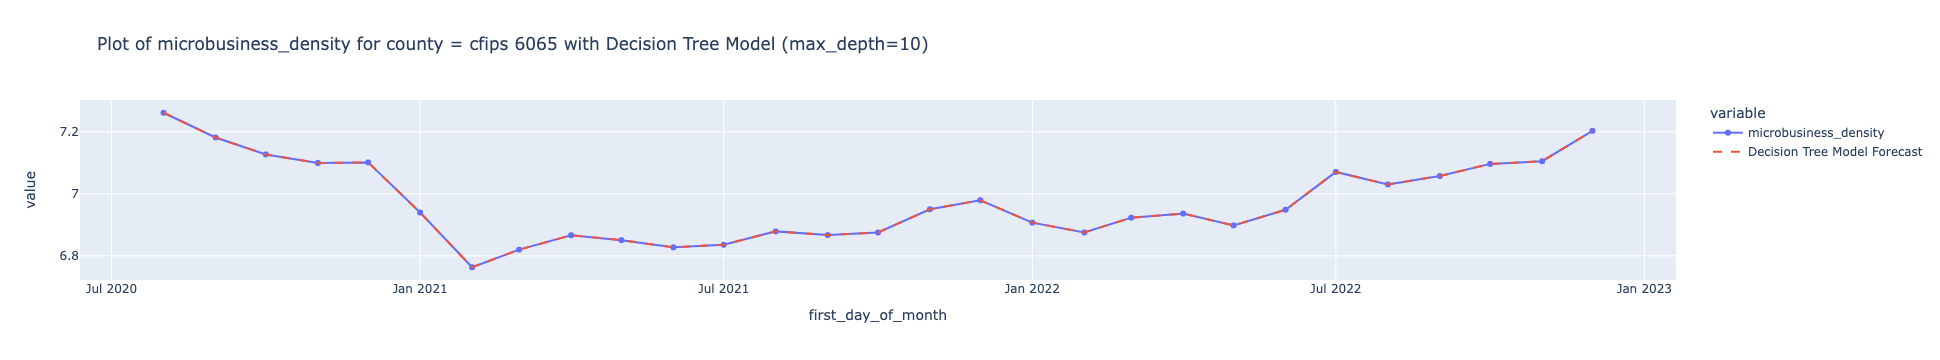

The Decision Tree model with max_depth=10 has a SMAPE of 0.00.
The best max_depth for the Decision Tree model is 7 with a SMAPE of 0.00.


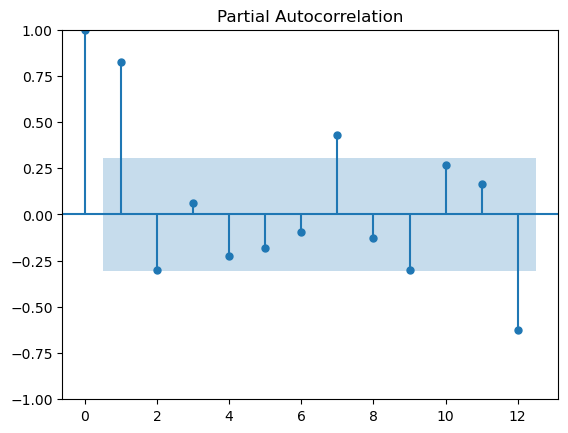

In [18]:
# assume y is a pandas series of the time series data
X = dp.in_sample()
y = subset_df[target]
for i in range(1, 13):
    X[f'y_lag_{i}'] = y.shift(i)

_ = plot_pacf(y, lags=12)

X = X.dropna()
y = y[X.index]

smape_vals = []
for max_depth in range(2, 11):
    cycle_model = DecisionTreeRegressor(max_depth=max_depth)  # max_depth is a hyper-parameter that requires careful tuning
    cycle_model.fit(X, y)

    y_pred = pd.Series(cycle_model.predict(X), index=X.index)

    fig = px.line(y, markers=True, title=f"Plot of {target} for county = cfips {cfips} with Decision Tree Model (max_depth={max_depth})")
    fig.add_scatter(x=y_pred.index, y=y_pred, line=dict(dash='dash'), name="Decision Tree Model Forecast")
    fig.update_layout(showlegend=True)
    fig.show()

    # Compute SMAPE
    smape_val = 100/len(y) * np.sum(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))
    smape_vals.append(smape_val)
    print(f"The Decision Tree model with max_depth={max_depth} has a SMAPE of {smape_val:.2f}.")

best_max_depth = np.argmin(smape_vals) + 2  # add 2 to account for range starting at 2
print(f"The best max_depth for the Decision Tree model is {best_max_depth} with a SMAPE of {smape_vals[best_max_depth-2]:.2f}.")


With this model, we will take care to address partial autocorrelations in our microbusiness_density valuations across each month of the calendar year--based on Choudhary's Kaggle Notebook (2023, February 15th), the code block below represents cycles of temporal autocorrelations across microbusines_density values for a particular cfips (county).

For the example county below, it seems months 2, 3, 4, 7, 8, and 10 represent points for which the forecasting model with cfips (6065) needs to reset itself essentially.

In [20]:
X = pd.DataFrame()
for i in [2, 3, 4, 7, 8, 10]:
    X[f'y_lag_{i}'] = y.shift(i)
    
X = X.dropna()
y = y[X.index]

In [21]:
cycle_model = DecisionTreeRegressor(max_depth=2)  # max_depth is a hyper-parameter that requires careful tuning
cycle_model.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [22]:
y_pred = pd.Series(cycle_model.predict(X), index=X.index)

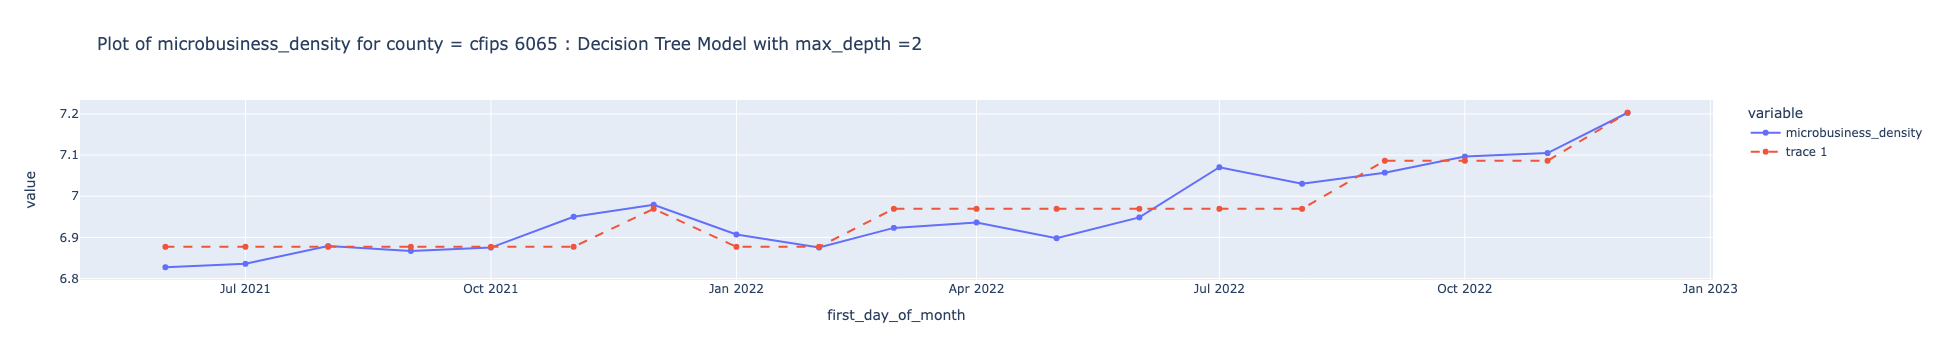

In [23]:
fig = px.line(y, markers=True, title=f"Plot of {target} for county = cfips {cfips} : Decision Tree Model with max_depth =2")
fig.add_scatter(x=y_pred.index, y=y_pred, line=dict(dash='dash'))
fig.update_layout(showlegend=True)
fig.show()

### Decision Tree Reflection

The decision tree produces excellent results in terms of its SMAPE accuracy across the board, becoming increasingly biased yet accurate as 'max_depth' hyperparameter increases. 


To avoid overfitting in this large dataset, we will not increase max_depth beyond 2 in our final combined forecasting model.

### Combined Model (mixing Linear Regressions and Decision Trees)

For the combined model below, we now have a method implemented via Linear Regression and Decision Tree to approximate fairly accurate curves to fit existing trends in microbusiness_density.

Knowing we have appropriated our model via decision tree to address a particular county's seasonal cycle of fluctuations in microbusiness_density, we can now build a larger model to address fluctuations across each geography with the time series.

This is where we now turn to widening our model's capacities for forecasting.

In [24]:
def predict_county_microbusinesses(cfips_id, ts_data, horizon_len=1, num_lag_features=1, pacf_threshold=0.0):
    dp = DeterministicProcess(
        index=ts_data.index,
        constant=True,
        order=2,
        drop=True,
        seasonal=True
    )
    
    # Trend and sesonality with Linear Model information
    X_trend_train = dp.in_sample()
    y_trend_train = ts_data[target]

    model = LinearRegression()
    model.fit(X_trend_train, y_trend_train)

    y_pred_trend_train = pd.Series(model.predict(X_trend_train), index=X_trend_train.index)

    X_trend_test = dp.out_of_sample(steps=horizon_len)
    y_pred_trend_test = pd.Series(model.predict(X_trend_test), index=X_trend_test.index)

    # Cycles and autocorrelation accounted via Decision Tree for forecasting ability

    y_cycle_train = y_trend_train - y_pred_trend_train  # detrended and deseasoned
    
    # if pacf threshold provided, select lag features based on correlelogram
    if pacf_threshold > 0.0:        
        lag_features = np.where(np.abs(pacf(y, 12))>=pacf_threshold)[0][1:]
    else:
        lag_features = np.arange(1, num_lag_features+1)
    X_cycle_train = pd.concat({f"lag_{i}":ts_data[target].shift(i) for i in lag_features}, axis=1).dropna()
    y_cycle_train = y_cycle_train.loc[X_cycle_train.index]

    y_pred_cycle_test = pd.Series()

    cycle_model = DecisionTreeRegressor(max_depth=None)
    cycle_model.fit(X_cycle_train, y_cycle_train)

    y_pred_cycle_train = pd.Series(cycle_model.predict(X_cycle_train), index=X_cycle_train.index)

    X_rolling_window = ts_data[target].values#.tolist()

    #identify lag resets based on autocorrelation shifts for each unique county
    for i in X_trend_test.index:
        y_pred_cycle_test[i] = cycle_model.predict([X_rolling_window[[-c for c in lag_features]]])[0]
        np.append(X_rolling_window, y_pred_cycle_test[i])

    y_pred_train = y_pred_trend_train.loc[y_pred_cycle_train.index] + y_pred_cycle_train

    y_pred_test = y_pred_trend_test + y_pred_cycle_test

    y_pred_test.name = target
    y_pred_test.index.name = 'first_day_of_month'

    y_pred_test = y_pred_test.reset_index()
    y_pred_test['row_id'] = y_pred_test['first_day_of_month'].dt.date.apply(lambda x: f"{cfips_id}_{x}")
    
    return y_pred_train, y_pred_test

In [25]:
def plot_cfips_ts(cfips_id, horizon_len=1, pacf_threshold=0.0, num_lag_features=1):
    ts_data = train_df.loc[train_df['cfips']==cfips_id].set_index('first_day_of_month').asfreq('MS')
    y_pred_train, y_pred_test = predict_county_microbusinesses(cfips_id, ts_data, horizon_len, num_lag_features, pacf_threshold)
    fig = px.line(ts_data[target], markers=True, title=f"{ts_data['county'][0]}, {ts_data['state'][0]} - cfips {cfips_id}")
    fig.add_scatter(x=y_pred_train.index, y=y_pred_train, line=dict(dash='dashdot'), name='train predicted')
    fig.add_scatter(x=y_pred_test['first_day_of_month'], y=y_pred_test[target], line=dict(dash='dash'), name='test predicted')
    fig.update_layout(showlegend=True, yaxis_title=target)
    fig.show()

In [26]:
cfips_id = np.random.choice(train_df['cfips'].unique())

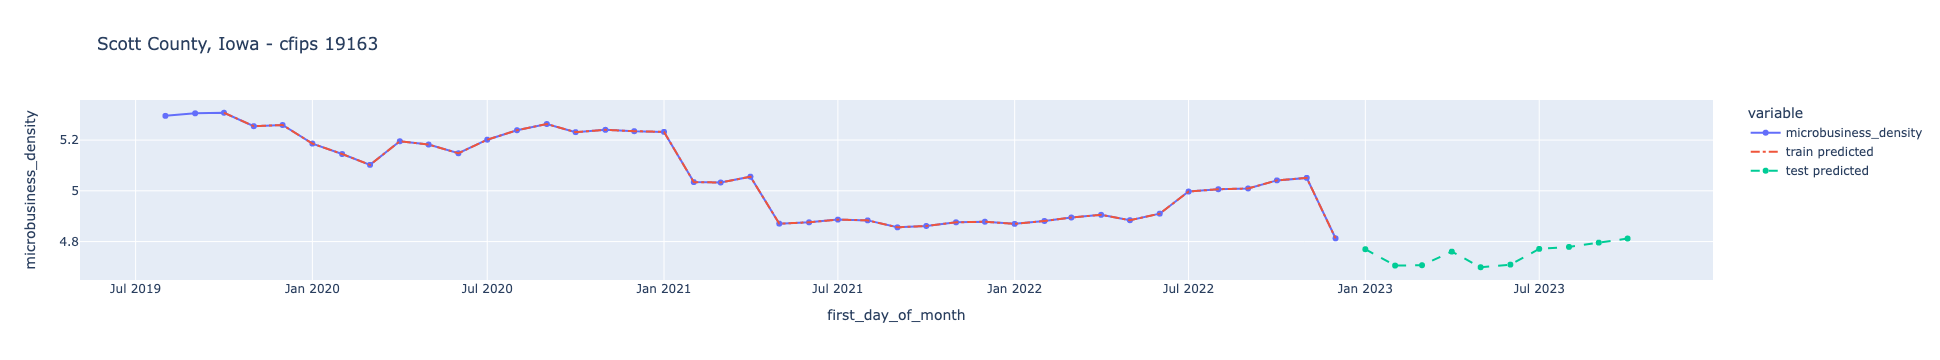

In [27]:
plot_cfips_ts(cfips_id, horizon_len=10, pacf_threshold=0.0, num_lag_features=2)

In [28]:
submission_df = []

for cfips_id in tqdm(test_df['cfips'].unique()):
    ts_data = train_df.loc[train_df['cfips']==cfips_id].set_index('first_day_of_month').asfreq('MS')
    y_pred_train, y_pred_test = predict_county_microbusinesses(cfips_id, ts_data, horizon_len=8, num_lag_features=2)  # predictions for the next eight months
    submission_df.append(y_pred_test)

submission_df = pd.concat(submission_df).drop(columns='first_day_of_month')

100%|██████████| 3135/3135 [00:33<00:00, 93.33it/s]


In [29]:
train_df['row_number'] = train_df.reset_index().index
submission_df['row_number'] = submission_df.reset_index().index
merged_df = train_df.merge(submission_df, on='row_number')
merged_df 

row_id_x  cfips           county     state first_day_of_month  \
0         1001   1001   Autauga County   Alabama         2019-08-01   
1         1001   1001   Autauga County   Alabama         2019-09-01   
2         1001   1001   Autauga County   Alabama         2019-10-01   
3         1001   1001   Autauga County   Alabama         2019-11-01   
4         1001   1001   Autauga County   Alabama         2019-12-01   
...        ...    ...              ...       ...                ...   
25075    17099  17099   LaSalle County  Illinois         2022-09-01   
25076    17099  17099   LaSalle County  Illinois         2022-10-01   
25077    17101  17101  Lawrence County  Illinois         2019-08-01   
25078    17101  17101  Lawrence County  Illinois         2019-09-01   
25079    17101  17101  Lawrence County  Illinois         2019-10-01   

       microbusiness_density_x    active  state_fips  county_fips  row_number  \
0                       3.0077 1249.0000           1            1           0   
1                       2.8849 1198.0000           1            1           1   
2                       3.0558 1269.0000           1            1           2   
3                       2.9932 1243.0000           1            1           3   
4                       2.9932 1243.0000           1            1           4   
...                        ...       ...         ...          ...         ...   
25075                   3.4400 2945.0000          17           99       25075   
25076                   3.4376 2943.0000          17           99       25076   
25077                   1.0585  141.0000          17          101       25077   
25078                   1.0735  143.0000          17          101       25078   
25079                   1.0735  143.0000          17          101       25079   

       microbusiness_density_y          row_id_y  
0                       3.4464   1001_2023-01-01  
1                       3.4987   1001_2023-02-01  
2                       3.5268   1001_2023-03-01  
3                       3.5944   1001_2023-04-01  
4                       3.5839   1001_2023-05-01  
...                        ...               ...  
25075                   1.8946  56045_2023-04-01  
25076                   1.9156  56045_2023-05-01  
25077                   1.9246  56045_2023-06-01  
25078                   1.8920  56045_2023-07-01  
25079                   1.9139  56045_2023-08-01  

[25080 rows x 12 columns]

### Conclusion

With the final combined forecasting model, we have predicted values across all 25,080 rows of data as well as forecasting provisions for 8 months beyond the timeframe of the known datapoints beyond January, 2023.

Next steps in assessing this model might include post-hoc comparison of actual vs. projected microbusiness density for February-October,2023--it would be very interesting to see exactly how accurate our projections become across counties in terms of their cumulative and month-by-month residual rates, MSE, and SMAPE valuations.

Given that certain counties and states inevitably ended up showing better overall accuracy in terms of regression fit and SMAPE valuation, a step that could be taken to improve this model is to split data into logical geographic regions and then merge several decision trees into an updated combined model.

### References

Brownlee, J. (2016, December 2). "What Is Time Series Forecasting?" in Machine Learning Mastery. 
> https://machinelearningmastery.com/time-series-forecasting/

Choudhary, C. (2023, Februarey 15th). "Time series hybrid modeling" from GoDaddy Microbusiness Forecasting [Codebook]. Kaggle.  
> https://kaggle.com/code/ch124uec/time-series-hybrid-modeling

GPreda. (2023). "GoDaddy Data Cleaning and EDA" from GoDaddy Microbusiness Density Forecasting [Codebook]. Kaggle. 
> https://www.kaggle.com/code/gpreda/godaddy-data-cleaning-and-eda#Check-the-cfips-from-census-data

Holbrook, R. (n.d.). "Time series: apply machine learning to real-world forecasting tasks" from Kaggle Learn.
> https://wwww.kaggle.com/learn/time-series

Kudelya, V. (2023). "Simple baseline with EDA and SMAPE behaviour" from GoDaddy Microbusiness Density Forecasting [Codebook]. Kaggle.
> https://www.kaggle.com/code/vitalykudelya/simple-baseline-with-eda-and-smape-behaviour

RCBhatt. (2023). GoDaddy Microbusiness Density Forecasting [Codebook]. Kaggle. 
> https://www.kaggle.com/code/rcbhatt/godaddy-microbusiness-density-forecasting